## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log
import os
import pickle

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [ ]:
%matplotlib inline

### load the dataset

In [2]:
### set your image dir here
# IMAGE_DIR = "./data/"
IMAGE_DIR = "/Users/sriramreddy/Downloads/ML/3/all/"

In [3]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR,subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [4]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170


/Users/sriramreddy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of images in val-set: 2724
Number of images in test-set: 5542


### displaying images

In [5]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

/Users/sriramreddy/Downloads/ML/3/all/train/1.png


/Users/sriramreddy/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


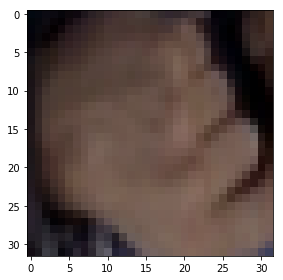

In [6]:
display(IMAGE_DIR+"train/1.png")

### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [28]:
# global Loss_epoch
from sklearn.utils import shuffle
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        self.w_epoch=[]
    def __sigmoid(self, x):
        return 1.0/(1 + np.exp(-x))
    def sigmoid_fun(self, x):
        return 1.0/(1 + np.exp(-x))
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)
        self.__bias = np.random.randn()
        return self.__wt,self.__bias
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        Loss_epoch=[np.Infinity]
        n, d = X.shape
#         print("n examples and d dimensions", n,d)
        self.__dimension = d
        if self.__init:
            self.__init_param()
        self.__w = np.asmatrix(np.vstack((self.__wt.T,np.matrix([self.__bias]))))
        
        X=np.asmatrix(np.hstack((X,np.ones((n,1)))))
        def loss(X,y):
            loss=0
            for i in range(n):
                p_1=(self.__sigmoid(np.dot(X[i],self.__w)))
                p_0=1-(p_1)
#                 loss=loss + y[i]*(p_1) + (1-y[i])*(p_0)
                loss=loss + y[i]*np.log(p_1) + (1-y[i])*np.log(p_0)
#                 print(p_1,p_0,loss)
#             print("loss for a epoch",loss*(-1/np.float(n)))
            return np.divide(-loss,n)
        for epoch in range(1,self.__max_epoch+1):
            learning_rate= (self.__eta0/(self.__eta1 + epoch))
#             This one thing, I have to check
            X,y=shuffle(X,y)
            m=self.__m
            batches=n//m
#             print(batches)
            y=np.asmatrix(y.reshape(n,1))
            for i in range(batches):
                X_i=X[i*m:(i+1)*m,]
                y_i=y[i*m:(i+1)*m]
                y_i=np.asmatrix(y_i.reshape(m,1))
                k=np.dot(X_i,self.__w)
                l=self.__sigmoid(k)
                b2=y_i-l
                grad=np.asmatrix(np.zeros_like(self.__w))
#                 for j in range(m):
#                     grad = grad + np.asscalar(b2[j])*(X_i[j].T)
#                     print("shape of X_i[j]",X_i[j].shape)
#                 t = self.__w + grad*(np.float(learning_rate)/np.float(m))
                self.__w = self.__w + (np.float(learning_rate)/np.float(m))*(X_i.T*b2)
#                 print("value of t", t[0:10])
#                 print("value of self.__w", self.__w[0:10])
#             lot_loss = (loss(X,y))
            Loss_all=np.divide(-(np.dot(y.T,np.log(self.__sigmoid(np.dot(X,self.__w)))) + np.dot((1-y).T,(np.log(1-self.__sigmoid(np.dot(X,self.__w)))))),np.float((n)))
#             kill=(-1/n)*(np.dot(y.T,np.log(self.__sigmoid(np.dot(X,self.__w)))) + np.dot((1-y).T,(np.log(1-self.__sigmoid(np.dot(X,self.__w))))))
#             kill2=(-1/np.float(n))*(np.dot(y.T,np.log(self.__sigmoid(np.dot(X,self.__w)))) + np.dot((1-y).T,(np.log(1-self.__sigmoid(np.dot(X,self.__w))))))
# #             print("shape of (1-y).T and 1-np.log(self)",(1-y).T.shape, (1-np.log(self.__sigmoid(np.dot(X,self.__w)))).shape)
#             print("Loss_all,epoch",Loss_all,epoch+1)
#             print("kill_loss and kill2",lot_loss, epoch+1)
            Loss_epoch.append(Loss_all)
            self.w_epoch.append(self.__w)
        
#  Values are given below
#             ('Loss_all,epoch', matrix([[1.20834098]]), 2)
# ('kill_loss and kill2', matrix([[9872.14579606]]), matrix([[1.20834098]]), 2)
            if Loss_all > (1-self.__delta)*Loss_epoch[-2]:
#                 print("epochs it took to converge",epoch+1)
                break
#             if np.abs(Loss_all - Loss_epoch[-1] ) <= self.__delta/100:
#                 print("epochs it took to converge",epoch+1)
#                 break
        return Loss_epoch
    
    def predict_proba(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
        n, d = X.shape
        X=np.hstack((X,np.ones((n,1))))
        return self.__sigmoid(np.dot(X,self.__w))
    def predict(self, X):
        """
        Classify the sample
        """
        return (self.predict_proba(X) >= 0.5).astype(int)
    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)
    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

## Question 2.3

### 1. Baseline Model

In [13]:
LR = LogisticRegression()
p=LR.fit(X_train,y_train)

In [18]:
print(len(p)-1,p[-1])

380 [[0.52885375]]


(a) Number of epochs till termination = 380_

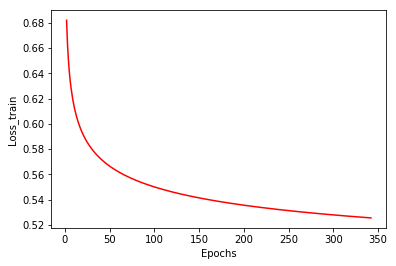

In [21]:
# (b) Plot L(theta) vs num_epochs

LR = LogisticRegression()
Loss_train = LR.fit(X_train,y_train)
Loss_val=[]
n, d = X_val.shape
# X=np.asmatrix(np.vstack((X_val,np.ones((n,1)))))
X=np.asmatrix(np.hstack((X_val,np.ones((n,1)))))
for i in range(len(LR.w_epoch)):
    W=np.asmatrix(LR.w_epoch[i])
    Loss_all=np.divide(-(np.dot(y_val.T,np.log(LR.sigmoid_fun(np.dot(X,W)))) + np.dot((1-y_val).T,(np.log(1-LR.sigmoid_fun(np.dot(X,W)))))),np.float((n)))
    Loss_val.append(np.asscalar(Loss_all))
# I need to restructure my code for getting the parameters per epoch
#I'm assuming that the plot requested is Loss v/s epochs for a fixed set of eta0 and eta1 and the loss incurred before converging to the optimum loss value
plt.plot(range(1,len(Loss_train)+1),Loss_train,'r')
#In case if you need validation, you can uncomment the above line.
# plt.plot(range(1,len(Loss_val)+1),Loss_val,'g')
#By using the theta parameters generated during training, we can generate the loss 
#Loss_val is the loss calculated for the validation set
# 
plt.ylabel('Loss_train')
plt.xlabel('Epochs')
plt.show()


(c) Final value of L($\theta$) after optimization = 0.52885375__

### 2. Experimenting with ($\eta_0$,$\eta_1$)

In [20]:
# Experimentation code goes here
# Experimentation code goes here
hyper_eta_0=[0.0001,0.001,0.01,0.1,1,10,100,1000]
hyper_eta_1=[0.0001,0.001,0.01,0.1,1,10,100,1000]
#This range is taken arbitarily. 
# Once we can refine the range, then we can tweak the parameters again.
for i in range(len(hyper_eta_0)):
    for j in range(len(hyper_eta_1)):
        LR = LogisticRegression(hyper_eta_0[i],hyper_eta_1[j])
        hyper_loss=LR.fit(X_train,y_train)
        print("hyper_parameter eta0",hyper_eta_0[i],"hyper_parameter eta1",hyper_eta_1[j],"  epoch ",len(hyper_loss)-1,"  Loss parameter ",hyper_loss[-1])

hyper_parameter eta0 0.0001 hyper_parameter eta1 0.0001   epoch  2   Loss parameter  [[0.68762008]]
hyper_parameter eta0 0.0001 hyper_parameter eta1 0.001   epoch  43   Loss parameter  [[0.88858402]]
hyper_parameter eta0 0.0001 hyper_parameter eta1 0.01   epoch  49   Loss parameter  [[0.89036777]]
hyper_parameter eta0 0.0001 hyper_parameter eta1 0.1   epoch  4   Loss parameter  [[0.75022136]]
hyper_parameter eta0 0.0001 hyper_parameter eta1 1   epoch  2   Loss parameter  [[0.67400974]]
hyper_parameter eta0 0.0001 hyper_parameter eta1 10   epoch  2   Loss parameter  [[0.8052938]]
hyper_parameter eta0 0.0001 hyper_parameter eta1 100   epoch  2   Loss parameter  [[0.70617764]]
hyper_parameter eta0 0.0001 hyper_parameter eta1 1000   epoch  2   Loss parameter  [[0.72050121]]
hyper_parameter eta0 0.001 hyper_parameter eta1 0.0001   epoch  96   Loss parameter  [[0.6795561]]
hyper_parameter eta0 0.001 hyper_parameter eta1 0.001   epoch  13   Loss parameter  [[0.7453953]]
hyper_parameter eta0 0

/Users/sriramreddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


hyper_parameter eta0 100 hyper_parameter eta1 0.001   epoch  7   Loss parameter  [[0.46024032]]
hyper_parameter eta0 100 hyper_parameter eta1 0.01   epoch  5   Loss parameter  [[0.41538894]]
hyper_parameter eta0 100 hyper_parameter eta1 0.1   epoch  8   Loss parameter  [[0.33787625]]
hyper_parameter eta0 100 hyper_parameter eta1 1   epoch  6   Loss parameter  [[0.28133041]]
hyper_parameter eta0 100 hyper_parameter eta1 10   epoch  5   Loss parameter  [[0.2706866]]
hyper_parameter eta0 100 hyper_parameter eta1 100   epoch  15   Loss parameter  [[0.29171708]]
hyper_parameter eta0 100 hyper_parameter eta1 1000   epoch  85   Loss parameter  [[0.30920232]]


/Users/sriramreddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


hyper_parameter eta0 1000 hyper_parameter eta1 0.0001   epoch  96   Loss parameter  [[0.39310327]]
hyper_parameter eta0 1000 hyper_parameter eta1 0.001   epoch  92   Loss parameter  [[0.40068188]]
hyper_parameter eta0 1000 hyper_parameter eta1 0.01   epoch  90   Loss parameter  [[0.43796087]]
hyper_parameter eta0 1000 hyper_parameter eta1 0.1   epoch  79   Loss parameter  [[0.37371804]]
hyper_parameter eta0 1000 hyper_parameter eta1 1   epoch  31   Loss parameter  [[0.40503408]]
hyper_parameter eta0 1000 hyper_parameter eta1 10   epoch  7   Loss parameter  [[1.14003903]]
hyper_parameter eta0 1000 hyper_parameter eta1 100   epoch  5   Loss parameter  [[0.31615577]]
hyper_parameter eta0 1000 hyper_parameter eta1 1000   epoch  10   Loss parameter  [[0.30543696]]


In [ ]:
# Experimentation code goes here
hyper_eta_0=[50]
hyper_eta_1=[4]
#This range is taken arbitarily. 
# Once we can refine the range, then we can tweak the parameters again.
for i in range(len(hyper_eta_0)):
    for j in range(len(hyper_eta_1)):
        LR = LogisticRegression(hyper_eta_0[i],hyper_eta_1[j])
        hyper_loss=LR.fit(X_train,y_train)
        print("hyper_parameter eta0",hyper_eta_0[i],"hyper_parameter eta0",hyper_eta_1[j],"  epoch ",len(hyper_loss)-1,"  Loss parameter ",hyper_loss[-1])

(a) Best value for, $\eta_0$ = \_100_, $\eta_1$ = \10_

Number of epochs for training = 5__

Final value of L($\theta$) = 0.2706866_

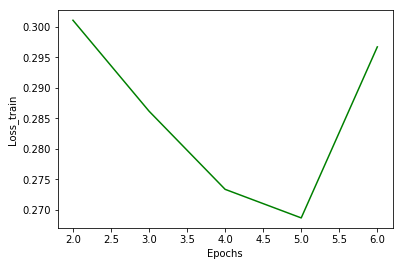

In [26]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs
# global Loss_epoch
from sklearn.utils import shuffle
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=100, eta1=10, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        self.w_epoch=[]
    def __sigmoid(self, x):
        return 1.0/(1 + np.exp(-x))
    def sigmoid_fun(self, x):
        return 1.0/(1 + np.exp(-x))
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)
        self.__bias = np.random.randn()
        return self.__wt,self.__bias
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        Loss_epoch=[np.Infinity]
        n, d = X.shape
#         print("n examples and d dimensions", n,d)
        self.__dimension = d
        if self.__init:
            self.__init_param()
        self.__w = np.asmatrix(np.vstack((self.__wt.T,np.matrix([self.__bias]))))
        
        X=np.asmatrix(np.hstack((X,np.ones((n,1)))))
        def loss(X,y):
            loss=0
            for i in range(n):
                p_1=(self.__sigmoid(np.dot(X[i],self.__w)))
                p_0=1-(p_1)
#                 loss=loss + y[i]*(p_1) + (1-y[i])*(p_0)
                loss=loss + y[i]*np.log(p_1) + (1-y[i])*np.log(p_0)
#                 print(p_1,p_0,loss)
#             print("loss for a epoch",loss*(-1/np.float(n)))
            return np.divide(-loss,n)
        for epoch in range(1,self.__max_epoch+1):
            learning_rate= (self.__eta0/(self.__eta1 + epoch))
#             This one thing, I have to check
            X,y=shuffle(X,y)
            m=self.__m
            batches=n//m
#             print(batches)
            y=np.asmatrix(y.reshape(n,1))
            for i in range(batches):
                X_i=X[i*m:(i+1)*m,]
                y_i=y[i*m:(i+1)*m]
                y_i=np.asmatrix(y_i.reshape(m,1))
                k=np.dot(X_i,self.__w)
                l=self.__sigmoid(k)
                b2=y_i-l
                grad=np.asmatrix(np.zeros_like(self.__w))
#                 for j in range(m):
#                     grad = grad + np.asscalar(b2[j])*(X_i[j].T)
#                     print("shape of X_i[j]",X_i[j].shape)
#                 t = self.__w + grad*(np.float(learning_rate)/np.float(m))
                self.__w = self.__w + (np.float(learning_rate)/np.float(m))*(X_i.T*b2)
#                 print("value of t", t[0:10])
#                 print("value of self.__w", self.__w[0:10])
#             lot_loss = (loss(X,y))
            Loss_all=np.divide(-(np.dot(y.T,np.log(self.__sigmoid(np.dot(X,self.__w)))) + np.dot((1-y).T,(np.log(1-self.__sigmoid(np.dot(X,self.__w)))))),np.float((n)))
#             kill=(-1/n)*(np.dot(y.T,np.log(self.__sigmoid(np.dot(X,self.__w)))) + np.dot((1-y).T,(np.log(1-self.__sigmoid(np.dot(X,self.__w))))))
#             kill2=(-1/np.float(n))*(np.dot(y.T,np.log(self.__sigmoid(np.dot(X,self.__w)))) + np.dot((1-y).T,(np.log(1-self.__sigmoid(np.dot(X,self.__w))))))
# #             print("shape of (1-y).T and 1-np.log(self)",(1-y).T.shape, (1-np.log(self.__sigmoid(np.dot(X,self.__w)))).shape)
#             print("Loss_all,epoch",Loss_all,epoch+1)
#             print("kill_loss and kill2",lot_loss, epoch+1)
            Loss_epoch.append(Loss_all)
            self.w_epoch.append(self.__w)
        
#  Values are given below
#             ('Loss_all,epoch', matrix([[1.20834098]]), 2)
# ('kill_loss and kill2', matrix([[9872.14579606]]), matrix([[1.20834098]]), 2)
            if Loss_all > (1-self.__delta)*Loss_epoch[-2]:
#                 print("epochs it took to converge",epoch+1)
                break
#             if np.abs(Loss_all - Loss_epoch[-1] ) <= self.__delta/100:
#                 print("epochs it took to converge",epoch+1)
#                 break
        return Loss_epoch
    
    def predict_proba(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
        n, d = X.shape
        X=np.hstack((X,np.ones((n,1))))
        return self.__sigmoid(np.dot(X,self.__w))
    def predict(self, X):
        """
        Classify the sample
        """
        return (self.predict_proba(X) >= 0.5).astype(int)
    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)
    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

LR= LogisticRegression()
p=LR.fit(X_train,y_train)
#In case if you need validation, you can uncomment the above line.
plt.plot(range(1,len(p)+1),p,'g')
#By using the theta parameters generated during training, we can generate the loss 
#Loss_val is the loss calculated for the validation set
plt.ylabel('Loss_train')
plt.xlabel('Epochs')
plt.show()

### 3. Evaluating on validation set

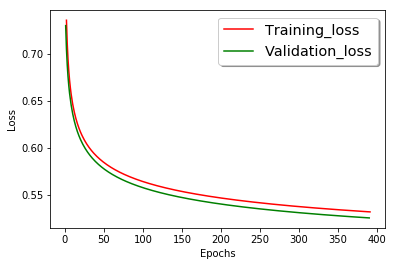

In [41]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure




LR = LogisticRegression()
Loss_train = LR.fit(X_train,y_train)
Loss_val=[]
n, d = X_val.shape
# X=np.asmatrix(np.vstack((X_val,np.ones((n,1)))))
X=np.asmatrix(np.hstack((X_val,np.ones((n,1)))))
for i in range(len(LR.w_epoch)):
    W=np.asmatrix(LR.w_epoch[i])
    Loss_all=np.divide(-(np.dot(y_val.T,np.log(LR.sigmoid_fun(np.dot(X,W)))) + np.dot((1-y_val).T,(np.log(1-LR.sigmoid_fun(np.dot(X,W)))))),np.float((n)))
    Loss_val.append(np.asscalar(Loss_all))
# I need to restructure my code for getting the parameters per epoch
#I'm assuming that the plot requested is Loss v/s epochs for a fixed set of eta0 and eta1 and the loss incurred before converging to the optimum loss value
plt.plot(range(1,len(Loss_train)+1),Loss_train,'r',label="Training_loss")
#In case if you need validation, you can uncomment the above line.
plt.plot(range(1,len(Loss_val)+1),Loss_val,'g',label="Validation_loss")
leg = plt.legend( shadow=True, fontsize='x-large')
#By using the theta parameters generated during training, we can generate the loss 
#Loss_val is the loss calculated for the validation set

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()


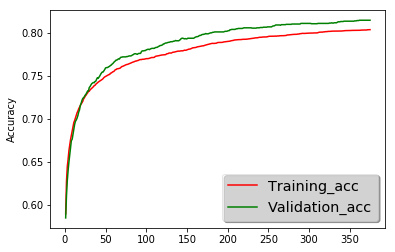

In [30]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure
from sklearn.metrics import accuracy_score
LR = LogisticRegression()
Loss_train = LR.fit(X_train,y_train)
n_v= X_val.shape[0]
n_t=X_train.shape[0]

X_val_c=np.asmatrix(np.hstack((X_val,np.ones((n_v,1)))))
X_train_c=np.asmatrix(np.hstack((X_train,np.ones((n_t,1)))))
Training_acc=[]
Validation_acc=[]
for i in range(len(LR.w_epoch)):
    y_pred_train =(LR.sigmoid_fun(np.dot(X_train_c,LR.w_epoch[i]))>= 0.5).astype(int)
    y_pred_val =(LR.sigmoid_fun(np.dot(X_val_c,LR.w_epoch[i]))>= 0.5).astype(int)
    Training_acc.append(accuracy_score(y_pred_train,y_train))
    Validation_acc.append(accuracy_score(y_pred_val,y_val))
    
plt.plot(range(1,len(Training_acc)+1),Training_acc,'r',label="Training_acc")
plt.plot(range(1,len(Validation_acc)+1),Validation_acc,'g',label="Validation_acc")
leg = plt.legend( shadow=True, fontsize='x-large')
#                  loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.ylabel('Accuracy')
plt.show()

### 4. ROC and Precision-Recall curves

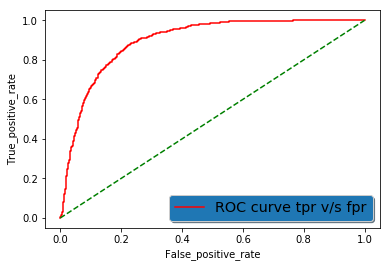

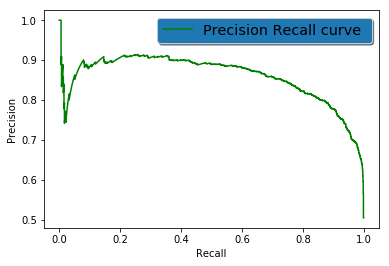

Area Under Curve for fpr and tpr 0.8955787571615552


In [37]:
#(a) Plot ROC curve on validation data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

LR = LogisticRegression()
Loss_train = LR.fit(X_train,y_train)
n_v= X_val.shape[0]
n_t=X_train.shape[0]
X_val_c=np.asmatrix(np.hstack((X_val,np.ones((n_v,1)))))
X_train_c=np.asmatrix(np.hstack((X_train,np.ones((n_t,1)))))
y_pred_train =(LR.sigmoid_fun(np.dot(X_train_c,LR.w_epoch[-1])))
y_pred_val =(LR.sigmoid_fun(np.dot(X_val_c,LR.w_epoch[-1])))

false_positive_rate, true_positive_rate,threshold = roc_curve(y_val,y_pred_val)
precision, recall, threshold = precision_recall_curve(y_val,y_pred_val)
plt.plot(false_positive_rate, true_positive_rate,'r',label="ROC curve tpr v/s fpr")
plt.plot([0,1],[0,1],'g--')
plt.xlabel('False_positive_rate')
plt.ylabel('True_positive_rate')

# leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.5)
legend = plt.legend( shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
plt.show()

# https://en.wikipedia.org/wiki/Receiver_operating_characteristic
#Area Under Curve as specified, I have imported from sklearn.
plt.plot(recall, precision, 'g', label="Precision Recall curve ")
plt.ylabel('Precision')
plt.xlabel('Recall')
# leg = plt.legend(ncol=2, mode="expand", shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.5) loc='upper center',
legend = plt.legend( shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
plt.show()
print(average_precision_score(y_val,y_pred_val))
print("Area Under Curve for fpr and tpr", auc(false_positive_rate, true_positive_rate))

Area under curve = 0.89557__

In [39]:
#(a) Plot Precision-Recall curve on validation data
print("Average precision curve",average_precision_score(y_val,y_pred_val))

Average precision curve 0.8586262157642053


In [ ]:
Average Precision = 0.85862__

## Question 2.4

### 1. Submission

In [36]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission.csv",index=0)       

#### Generate the submission.csv

In [40]:
# code goes here
y_pred=LR.predict(X_test)
submission(y_pred)

Best obtained accuracy on Public Leader-board = 0.88127
6
__%